# Indroduction

In my baseline model I worked with the pretrained model MobileNetV2 as it was small and easy to use. I used a subset of my data only working with 10 insted of my 101 species as colab could not handle all the data.
I will try to work with more classes here, but I will have to get my data more balanced as sfor some species I have several 1000 images and for others I only have 100.

I will try and work with a VGG architecture as this pretrained model has been used in a lot of classification task and sounds promising for my problem.

In [1]:
#installing packages

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import mixed_precision
from tensorflow.keras.layers import Input, RandomFlip, RandomRotation, RandomZoom, Rescaling
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Mixed Precision Policy auf 'mixed_float16' setzen
mixed_precision.set_global_policy('mixed_float16')

import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import shutil
import random
from pathlib import Path
import numpy as np

In [2]:
#get my data from kaggle
!pip install kaggle
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

!kaggle datasets download -d michaelkloster/ude-diatoms-in-the-wild-2024

#unzip the dataset
!unzip /content/ude-diatoms-in-the-wild-2024.zip

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: UDE Diatoms in the Wild 2024-Subset_n50/UDE Diatoms in the Wild 2024-Subset_n50/val/Navicula cryptocephala/Tunesien_TWH_S02_2022.x_6355.y_41908.png  
  inflating: UDE Diatoms in the Wild 2024-Subset_n50/UDE Diatoms in the Wild 2024-Subset_n50/val/Navicula cryptotenella/Frankreich_FLB_S1_UP_20220510.x_34037.y_42040.png  
  inflating: UDE Diatoms in the Wild 2024-Subset_n50/UDE Diatoms in the Wild 2024-Subset_n50/val/Navicula cryptotenella/Frankreich_FLM_S6_20220511.x_15689.y_43936.png  
  inflating: UDE Diatoms in the Wild 2024-Subset_n50/UDE Diatoms in the Wild 2024-Subset_n50/val/Navicula cryptotenella/Frankreich_FLM_S6_20220511.x_22586.y_44152.png  
  inflating: UDE Diatoms in the Wild 2024-Subset_n50/UDE Diatoms in the Wild 2024-Subset_n50/val/Navicula cryptotenella/Frankreich_FLM_S6_20220511.x_26439.y_43667.png  
  inflating: UDE Diatoms in the Wild 2024-Subset_n50/UDE Diatoms in the Wild 2024-Subset_n5

# Data handling

Even tough this might not be super realistic I want a nice balanced dataset which I will then use to decide on which model I am using for my task.
Some species are overrepresented in the number of pictures there are. Lets clean tht up, so that I have 100 images for each species.
These I can then split in 60 images trainig data, 20 vaildation images and 20 test images.

I am not able to handle 101 species as my model would run way to long and I will not be able to reach my goal in time. I will cut down my dataset to 50 species. Using every second species in the dataset


['Achnanthidium subatomus', 'Gomphonema calcifugum', 'Humidophila contenta', 'Achnanthidium eutrophilum', 'Sellaphora raederae', 'Cyclostephanos dubius', 'Navicula upsaliensis', 'Nitzschia vermicularis', 'Caloneis lancettula', 'Tabularia fasciculata', 'Pantocksekiella ocellata', 'Encyonema ventricosum', 'Gomphonema minutum', 'Reimeria sinuata', 'Gomphonema elegantissimum', 'Sellaphora seminulum', 'Navicula cryptotenelloides', 'Navicula slesvicensis', 'Achnanthidium delmontii', 'Navicula erifuga', 'Stephanodiscus hantzschii', 'Diatoma moniliformis', 'Navicula simulata', 'Navicymbula pusilla', 'Encyonopsis minuta']
25


species                  subset
Achnanthidium atomoides  test      160
                         train     478
                         val       160
Achnanthidium delmontii  test       23
                         train      66
                                  ... 
Tabularia fasciculata    train      74
                         val        25
Ulnaria ulna             test       31
                         train      89
                         val        31
Length: 303, dtype: int64

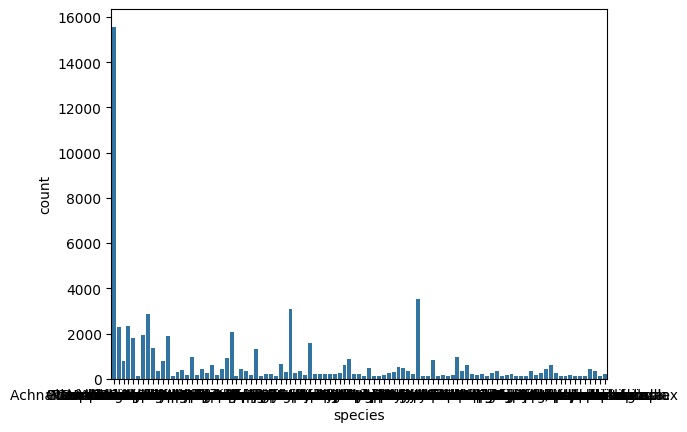

In [3]:
# count how many images each species has in the n_100 dataset


#look at the CSV of the n_100 dataset
df_100_test = pd.read_csv('/content/UDE Diatoms in the Wild 2024-Subset_n100/UDE Diatoms in the Wild 2024-Subset_n100/UDE_Diatoms_in_the_Wild_2024.subset_n100_test.csv')
df_100_train = pd.read_csv('/content/UDE Diatoms in the Wild 2024-Subset_n100/UDE Diatoms in the Wild 2024-Subset_n100/UDE_Diatoms_in_the_Wild_2024.subset_n100_train.csv')
df_100_val = pd.read_csv('/content/UDE Diatoms in the Wild 2024-Subset_n100/UDE Diatoms in the Wild 2024-Subset_n100/UDE_Diatoms_in_the_Wild_2024.subset_n100_val.csv')

#merge the dataframes into one
df_100 = pd.concat([df_100_test, df_100_train, df_100_val])

#plot to show how unbalanced the distribution of images is among the species
sns.countplot(data=df_100, x='species')  # z. B. für ein Merkmal wie "Geschlecht"

#list all species, with les than 150
species_100 = df_100['species'].value_counts()[df_100['species'].value_counts() <= 150].index.tolist()
print(species_100)
print(len(species_100))

#print the number of images for each species
df_100['species'].value_counts()
# print how many images are test, train and validation for each species
#pd.set_option('display.max_rows', 1000)
df_100.groupby(['species', 'subset']).size()

#

In [4]:
#lets create my subset of the data I want to work with
!mkdir /content/diatom_subset3

# Parameters
SOURCE_BASE = Path("/content/UDE Diatoms in the Wild 2024-Subset_n100/UDE Diatoms in the Wild 2024-Subset_n100")
TARGET_BASE = Path("/content/diatom_subset3")
SPLIT_COUNTS = {'train': 60, 'val': 20, 'test': 20}
SEED = 42

random.seed(SEED)


# Alle Spezies aus allen Splits sammeln
species_to_images = {}

for split in ['train', 'val', 'test']:
    split_path = SOURCE_BASE / split
    for species_dir in split_path.iterdir():
        if species_dir.is_dir():
            species = species_dir.name
            images = [f for f in species_dir.glob("*") if f.is_file() and f.suffix.lower() in ['.jpg', '.jpeg', '.png', '.tif']]

            if species not in species_to_images:
                species_to_images[species] = []
            species_to_images[species].extend(images)

# 🎯 Spezies alphabetisch sortieren und jede zweite nehmen
sorted_species = sorted(species_to_images.keys())
selected_species = sorted_species[::2]  # jede zweite

print(f"➡️  Verwende {len(selected_species)} von {len(sorted_species)} Spezies")

# Zielverzeichnisse anlegen
for split in SPLIT_COUNTS:
    (TARGET_BASE / split).mkdir(parents=True, exist_ok=True)

# Bilder kopieren
for species in selected_species:
    all_images = species_to_images[species]

    if len(all_images) < sum(SPLIT_COUNTS.values()):
        print(f"⚠️ Skipping {species}: only {len(all_images)} images available")
        continue

    selected_images = random.sample(all_images, sum(SPLIT_COUNTS.values()))

    start = 0
    for split, count in SPLIT_COUNTS.items():
        split_dir = TARGET_BASE / split / species
        split_dir.mkdir(parents=True, exist_ok=True)

        for img_path in selected_images[start:start + count]:
            shutil.copy(img_path, split_dir)
        start += count

    print(f"✅ Processed {species}")



➡️  Verwende 51 von 101 Spezies
✅ Processed Achnanthidium atomoides
✅ Processed Achnanthidium eutrophilum
✅ Processed Achnanthidium lineare
✅ Processed Achnanthidium pyrenaicum
✅ Processed Achnanthidium saprophilum
✅ Processed Achnanthidium subatomus
✅ Processed Amphora indistincta
✅ Processed Aulacoseira granulata
✅ Processed Cocconeis pediculus
✅ Processed Conticribra weissflogii
✅ Processed Cyclostephanos dubius
✅ Processed Cyclotella atomus
✅ Processed Cyclotella meneghiniana (Stephanocyclus meneghiniana)
✅ Processed Diatoma moniliformis
✅ Processed Discostella pseudostelligera
✅ Processed Encyonema silesiacum
✅ Processed Encyonopsis minuta
✅ Processed Fragilaria deformis
✅ Processed Fragilaria rinoi
✅ Processed Gomphonella olivacea
✅ Processed Gomphonema elegantissimum
✅ Processed Gomphonema minutum
✅ Processed Gomphonema pumilum
✅ Processed Gyrosigma acuminatum
✅ Processed Humidophila contemnata
✅ Processed Humidophila simplex
✅ Processed Mayamaea permitis
✅ Processed Meridion ci

# Model
After I created my data subset I can now try and create a good model for my task. I want to work with a VGG model, as they have earlier proven quite good in biological classification tasks.

In [5]:
# I had problems, that my jupyter checkpoints were detected as classes
#so therefore I am deleting them

checkpoints_path = '/content/diatom_subset3/train/.ipynb_checkpoints'
if os.path.exists(checkpoints_path):
    shutil.rmtree(checkpoints_path)
    print("✅ Removed .ipynb_checkpoints from train/")
else:
    print("✅ No .ipynb_checkpoints folder found.")

for split in ['train', 'val', 'test']:
    cp_path = f'/content/diatom_subset3/{split}/.ipynb_checkpoints'
    if os.path.exists(cp_path):
        shutil.rmtree(cp_path)
        print(f"✅ Removed .ipynb_checkpoints from {split}/")

✅ No .ipynb_checkpoints folder found.


At first I loaded my data using image data generator / flow_from_directory. This did however not work as my models were really slow. I decided to switch to image_dataset_from_directory as this allowed me to use cache and buffer, which should hopefully speed up my trainig of the model.

In [6]:
# --- Parameter ---
base_dir = '/content/diatom_subset3'
img_size = (160, 160)
batch_size = 64
AUTOTUNE = tf.data.AUTOTUNE

# --- 1. Dataset laden (ohne Transformationen) ---
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'train'),
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'  # One-Hot-Encoding für Klassifikation
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'val'),
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

test_ds_raw = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'test'),
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=False  # Wichtig für Testset, um Reihenfolge zu behalten
)

# --- 2. Klassen und Anzahl speichern ---
class_names = train_ds_raw.class_names
num_classes = len(class_names)
print(f"Gefundene Klassen: {num_classes} -> {class_names}")

# --- 3. Normalisierung Layer erstellen ---
normalization_layer = tf.keras.layers.Rescaling(1./255)

# --- 4. Normalisierung, Cachen und Prefetching ---
def prepare_dataset(dataset):
    dataset = dataset.map(lambda x, y: (normalization_layer(x), y))  # Pixel auf [0,1] skalieren
    dataset = dataset.cache()   # Nach dem ersten Laden im Speicher behalten
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)  # Im Hintergrund laden, damit GPU/TPU nicht warten muss
    return dataset

train_ds = prepare_dataset(train_ds_raw)
val_ds = prepare_dataset(val_ds_raw)
test_ds = prepare_dataset(test_ds_raw)

Found 3060 files belonging to 51 classes.
Found 1020 files belonging to 51 classes.
Found 1020 files belonging to 51 classes.
Gefundene Klassen: 51 -> ['Achnanthidium atomoides', 'Achnanthidium eutrophilum', 'Achnanthidium lineare', 'Achnanthidium pyrenaicum', 'Achnanthidium saprophilum', 'Achnanthidium subatomus', 'Amphora indistincta', 'Aulacoseira granulata', 'Cocconeis pediculus', 'Conticribra weissflogii', 'Cyclostephanos dubius', 'Cyclotella atomus', 'Cyclotella meneghiniana (Stephanocyclus meneghiniana)', 'Diatoma moniliformis', 'Discostella pseudostelligera', 'Encyonema silesiacum', 'Encyonopsis minuta', 'Fragilaria deformis', 'Fragilaria rinoi', 'Gomphonella olivacea', 'Gomphonema elegantissimum', 'Gomphonema minutum', 'Gomphonema pumilum', 'Gyrosigma acuminatum', 'Humidophila contemnata', 'Humidophila simplex', 'Mayamaea permitis', 'Meridion circulare', 'Navicula cryptocephala', 'Navicula cryptotenelloides', 'Navicula germainii', 'Navicula lanceolata', 'Navicula recens', 'Nav

In [7]:
# Alle Klassen in jedem Split anzeigen
train_classes = set(os.listdir('/content/diatom_subset3/train'))
val_classes = set(os.listdir('/content/diatom_subset3/val'))
test_classes = set(os.listdir('/content/diatom_subset3/test'))

print(f"Train classes: {len(train_classes)}")
print(f"Val classes: {len(val_classes)}")
print(f"Test classes: {len(test_classes)}")

# Welche Klassen fehlen?
print("❌ Klassen in Train, aber NICHT in Val:", train_classes - val_classes)
print("❌ Klassen in Train, aber NICHT in Test:", train_classes - test_classes)

Train classes: 51
Val classes: 51
Test classes: 51
❌ Klassen in Train, aber NICHT in Val: set()
❌ Klassen in Train, aber NICHT in Test: set()


In [ ]:
# Basis-Modell: VGG16 ohne Klassifikationskopf (top layer)
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(160, 160, 3))

# Basis-Modell einfrieren, damit die vortrainierten Features nicht verändert werden
base_model.trainable = False

# Eigenes Modell zusammenbauen
model = models.Sequential([
    base_model,                # vortrainiertes CNN
    layers.Flatten(),          # von 3D-Feature-Maps zu 1D-Vektor
    #layers.Dense(256, activation='relu'),  # dichte Schicht mit ReLU
    layers.Dense(128, activation='relu'),  # dichte Schicht mit ReLU, schauen ob mein modell schneller wird
    layers.Dropout(0.5),       # Regularisierung gegen Overfitting
    layers.Dense(num_classes, activation='softmax', dtype='float32') #angepasst für mixed precision
    #layers.Dense(num_classes, activation='softmax')  # finale Softmax-Schicht für Klassifikation
])

# Kompilieren des Modells
model.compile(
    loss='categorical_crossentropy',           # Verlustfunktion für Mehrklassen-Klassifikation
    optimizer=optimizers.Adam(learning_rate=0.0001),  # Adam-Optimizer mit kleinem Lernrate
    metrics=['accuracy']                        # Genauigkeit als Metrik
)

# Modellübersicht ausgeben
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 5, 5, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 51)             │         6,579 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,359,795 (62.41 MB)

 Trainable params: 1,645,107 (6.28 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds
)

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1466s 31s/step - accuracy: 0.1936 - loss: 3.1601 - val_accuracy: 0.2588 - val_loss: 3.0820
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1466s 31s/step - accuracy: 0.2250 - loss: 3.0843 - val_accuracy: 0.3020 - val_loss: 2.9897
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1441s 30s/step - accuracy: 0.2453 - loss: 2.9792 - val_accuracy: 0.2931 - val_loss: 2.9011
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1437s 30s/step - accuracy: 0.2583 - loss: 2.8854 - val_accuracy: 0.3235 - val_loss: 2.8249
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1433s 30s/step - accuracy: 0.2720 - loss: 2.8045 - val_accuracy: 0.3265 - val_loss: 2.7579
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1424s 30s/step - accuracy: 0.2841 - loss: 2.7456 - val_accuracy: 0.3422 - val_loss: 2.6950
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1463s 30s/step - accuracy: 0.3096 - loss: 2.6639 - val_accuracy: 0.3588 - val_loss: 2.6249
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1464s 30s/step - accuracy: 0.3297 - loss: 2.5905 - val_accu

In [ ]:

test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_acc:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 368s 23s/step - accuracy: 0.3646 - loss: 2.5857
✅ Test Accuracy: 0.4118


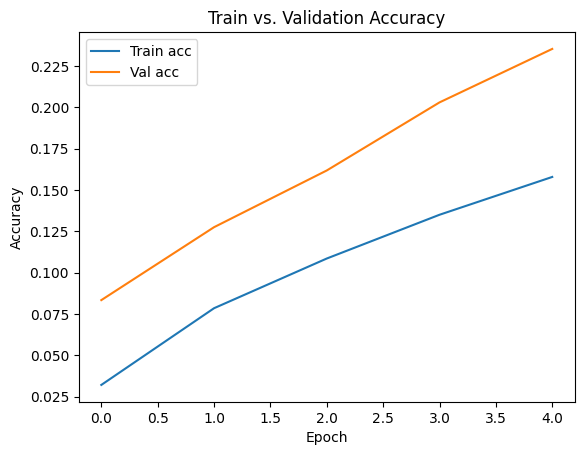

In [ ]:
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs. Validation Accuracy')
plt.legend()
plt.show()

I am really struggeling with how large the model is, and how long the trainig takes. If I train for 10 epochs I only get a accuracy of 30 percent and can see, that it is still getting better with every epoch, however it takes really long.

Maybe I try and do it one more time with the MovileNetV2 model.

In [8]:

# 1. Lade das vortrainierte Modell OHNE top-Classifier
base_model_2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=img_size + (3,))
base_model_2.trainable = False  # Freeze Base Model

# 2. Datenaugmentation + Normalisierung
data_augmentation = tf.keras.Sequential([
    #RandomFlip("horizontal"),
    RandomRotation(0.05),
    RandomZoom(0.05),

])

#callbacks einbauen
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True)
]

# 3. Erstelle das neue Modell
inputs = Input(shape=img_size + (3,))
x = data_augmentation(inputs)              # Augmentation (nur beim Training aktiv)
#x = Rescaling(1./255)(x)                   # Normalisierung
x = base_model_2(x, training=False)        # Feature-Extraktion
x = GlobalAveragePooling2D()(x)            # Globales Pooling
outputs = Dense(num_classes, activation='softmax')(x)  # Klassifikation

model = Model(inputs, outputs)

# 4. Kompilieren
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 5. Training starten
history = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks= callbacks)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 521s 11s/step - accuracy: 0.0704 - loss: 4.0751 - val_accuracy: 0.2716 - val_loss: 2.6158
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 552s 12s/step - accuracy: 0.3663 - loss: 2.3551 - val_accuracy: 0.3765 - val_loss: 2.1609
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 469s 10s/step - accuracy: 0.5063 - loss: 1.8570 - val_accuracy: 0.4137 - val_loss: 1.9799
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 474s 10s/step - accuracy: 0.5735 - loss: 1.6060 - val_accuracy: 0.4500 - val_loss: 1.8741
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 496s 10s/step - accuracy: 0.6085 - loss: 1.4435 - val_accuracy: 0.4667 - val_loss: 1.8200
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 497s 10s/step - accuracy: 0.6517 - loss: 1.3135 - val_accuracy: 0.4882 - val_loss: 1.7658
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 473s 10s/step - accuracy: 0.6722 - loss: 1.2184 - val_accuracy: 0.4912 - val_loss: 1.7419
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 497s 10s/step - a

In [9]:
from sklearn.metrics import classification_report
import numpy as np

y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred = model.predict(test_ds)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_true, axis=1)

print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

16/16 ━━━━━━━━━━━━━━━━━━━━ 133s 8s/step
                                                       precision    recall  f1-score   support

                              Achnanthidium atomoides       0.41      0.35      0.38        20
                            Achnanthidium eutrophilum       0.09      0.10      0.10        20
                                Achnanthidium lineare       0.32      0.30      0.31        20
                             Achnanthidium pyrenaicum       0.28      0.25      0.26        20
                            Achnanthidium saprophilum       0.19      0.20      0.20        20
                              Achnanthidium subatomus       0.64      0.70      0.67        20
                                  Amphora indistincta       0.79      0.75      0.77        20
                                Aulacoseira granulata       0.80      0.60      0.69        20
                                  Cocconeis pediculus       0.76      0.95      0.84        20
         

In [10]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_acc:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 113s 7s/step - accuracy: 0.4669 - loss: 1.6681
✅ Test Accuracy: 0.4980


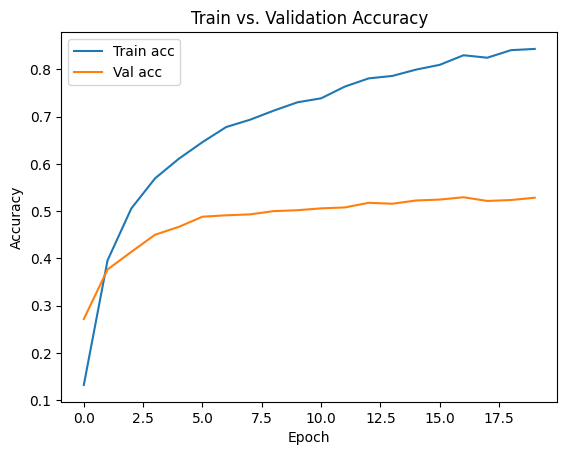

In [11]:
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs. Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
#print 1 out of every test folder
import random
import matplotlib.pyplot as plt







